In [1]:
import os
os.chdir("D:/Pinelopi/Documents/Σημαντικά/Data Scientist/Project/Original Data/EEA") #Set working directory
os.getcwd()

#Import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f_oneway
import numpy as np

#Import libraries for Machine Learning models
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression
from sklearn.metrics          import mean_squared_error
from sklearn.metrics          import mean_absolute_error
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
#Import file
df= pd.read_csv("CO2_2019_preprocessed.csv") #Import file with the preprocessed data
df.info() #Display basic information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148704 entries, 0 to 148703
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CO2                      148704 non-null  float64
 1   Mass                     148704 non-null  float64
 2   Axle_Width               148704 non-null  float64
 3   Wheel_Base               148704 non-null  float64
 4   Eng_Capacity             148697 non-null  float64
 5   Eng_Power                126707 non-null  float64
 6   Manufacturer             148704 non-null  object 
 7   Country                  148704 non-null  object 
 8   Vehicle_Category         148704 non-null  object 
 9   Fuel_Type                148704 non-null  object 
 10  Fuel_Mode                148704 non-null  object 
 11  Four_Wheel_Drive         148704 non-null  int64  
 12  Fuel_Mode_B              148704 non-null  int64  
 13  Fuel_Mode_F              148704 non-null  int64  
 14  Fuel

In [4]:
#Create dummy variables for the most popular manufacturers in the dataset.

#Make dataframe with the top 10 manufacturers
top_10 = df['Manufacturer'].value_counts().head(10).index.tolist() #Identify the 10 most popular manufacturers
df_10 = df[df['Manufacturer'].isin(top_10)] #Filter dataframe
dummies_10 = pd.get_dummies(df_10['Manufacturer']) #Create the dummy variables
df_10 = df_10.join(dummies_10) #Merge dataframe with dummy variables
df_10.drop('Manufacturer', axis = 1, inplace = True) #Delete original Manufacturer column
df_10= df_10.replace({False: 0, True: 1}) #Replace Boolean values with 0 and 1

In [9]:
df_10.head() #Display dataframe with dummy variable for the top 10 manufacturers.

,CO2,Mass,Axle_Width,Wheel_Base,Eng_Capacity,Eng_Power,Country,Vehicle_Category,Fuel_Type,Fuel_Mode,...,AUTOMOBILES PEUGEOT,BMW AG,DAIMLER AG,FIAT GROUP,FORD WERKE GMBH,RENAULT,SKODA,TOYOTA,VOLKSWAGEN,CO2_Classes
0,102.0,1394.0,1565.0,2730.0,1499.0,96.0,DE,M1,diesel,M,...,1,0,0,0,0,0,0,0,0,B
5,180.0,1615.0,1535.0,2690.0,2998.0,250.0,FR,M1,petrol,M,...,0,1,0,0,0,0,0,0,0,E
7,137.0,1550.0,1547.0,2587.0,1968.0,110.0,IT,M1,diesel,M,...,0,0,0,0,0,0,0,0,0,D
8,113.0,1050.0,1413.0,2300.0,1242.0,51.0,LT,M1,petrol,M,...,0,0,0,1,0,0,0,0,0,C
9,110.0,1050.0,1470.0,2538.0,1199.0,61.0,ES,M1,petrol,M,...,1,0,0,0,0,0,0,0,0,B


Text(0, 0.5, 'Frequency')

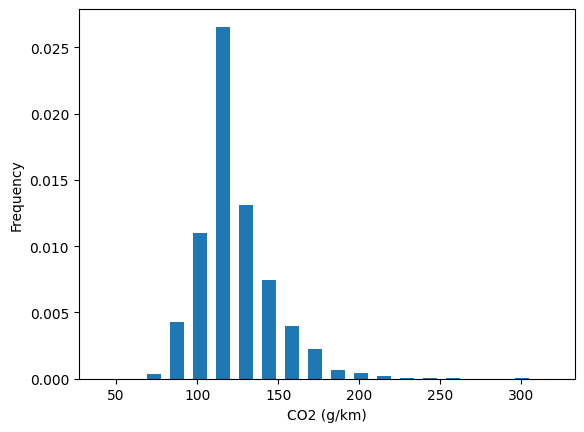

In [75]:
#Display distribution of the C02 emissions variable with the histogram
plt.hist(df_10["CO2_Eng_given"], bins=20, rwidth=0.6, density=True)
plt.xlabel('CO2 (g/km)')
plt.ylabel('Frequency')

In [6]:
#In order to apply Machine learning algorithms for Classification, we firstly need to create car classes based on CO2 emissions of each vehicle.
# Based on the distribution of the emissions, we will create the classes as seen below:

df_10["CO2_Classes"]=pd.cut(x = df_10['CO2_Eng_given'], bins = [0, 90, 110, 130, 150, 200, 250], labels= ['A', 'B', 'C', 'D', "E", "F"])
print(df_10['CO2_Classes'].value_counts()) #Display unique values for every class

CO2_Classes
C    34405
B    19340
D    14356
E     8444
A     3308
F      674
Name: count, dtype: int64


Text(0, 0.5, 'Car number')

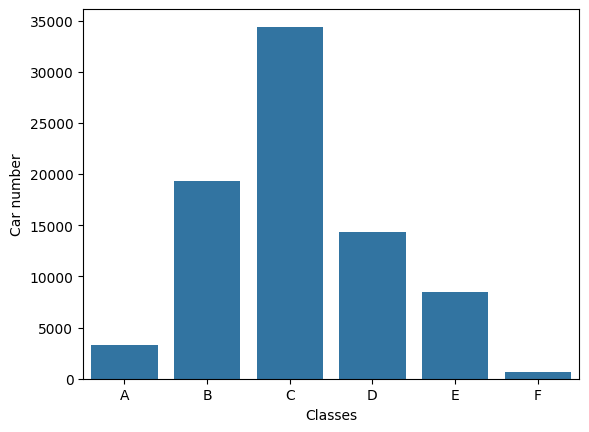

In [77]:
#Display the number of cars distributed across the different classes
sns.countplot(x='CO2_Classes', data=df_10)
plt.xlabel('Classes')
plt.ylabel('Car number')

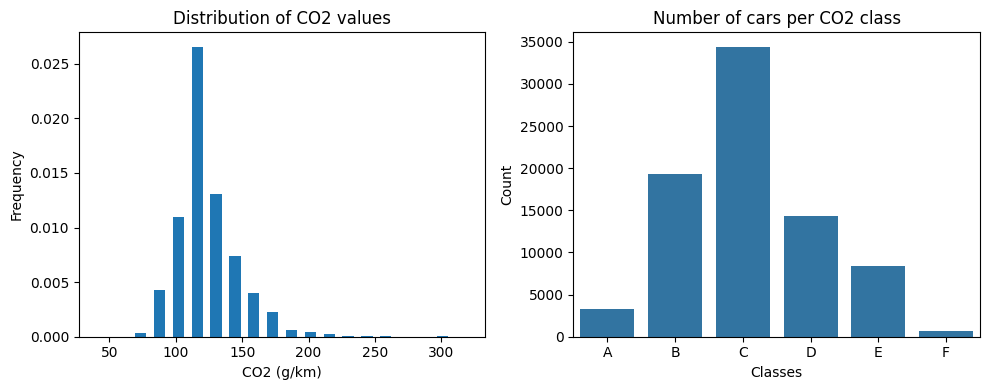

In [81]:
#Plot again to create a final figure, that includes the two plots from above.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].hist(df_10["CO2_Eng_given"], bins=20, rwidth=0.6, density=True)
axes[0].set_title('Distribution of CO2 values')
axes[0].set_xlabel('CO2 (g/km)')
axes[0].set_ylabel('Frequency')

sns.countplot(x='CO2_Classes', ax=axes[1], data=df_10)
axes[1].set_title('Number of cars per CO2 class')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Count')

plt.tight_layout() ## Adjust layout to prevent clipping of titles

plt.show()

In [7]:
# Select the final variables
df_class=df_10.drop(["CO2","CO2_Eng_given","CO2_Eng_misses","Country","Vehicle_Category","Fuel_Type","Fuel_Mode", "Eng_Power_missing"], axis=1)
df_class=df_class.dropna()
df_class.info()
print(df_class.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 80525 entries, 0 to 148702
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Mass                     80525 non-null  float64 
 1   Axle_Width               80525 non-null  float64 
 2   Wheel_Base               80525 non-null  float64 
 3   Eng_Capacity             80525 non-null  float64 
 4   Eng_Power                80525 non-null  float64 
 5   Four_Wheel_Drive         80525 non-null  int64   
 6   Fuel_Mode_B              80525 non-null  int64   
 7   Fuel_Mode_F              80525 non-null  int64   
 8   Fuel_Mode_H              80525 non-null  int64   
 9   Fuel_Mode_M              80525 non-null  int64   
 10  Fuel_Type_diesel         80525 non-null  int64   
 11  Fuel_Type_e85            80525 non-null  int64   
 12  Fuel_Type_lpg            80525 non-null  int64   
 13  Fuel_Type_ng             80525 non-null  int64   
 14  Fuel_Type_

In [17]:
# Split data to test and train subset
target = df_class.CO2_Classes #Select target variable
data =df_class.drop( "CO2_Classes", axis=1) 
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=66) #Split into train and test

In [18]:
#Scale only the numerical variables
from sklearn import preprocessing
data_to_scale=df_class.drop( "CO2_Classes", axis=1)
columns_to_scale = ["Mass","Axle_Width", "Wheel_Base","Eng_Capacity","Eng_Power","ERT"]

#Create a MinMaxScaler
scaler = preprocessing.StandardScaler()

# Fit and transform the selected columns
data_to_scale[columns_to_scale] = scaler.fit_transform(data_to_scale[columns_to_scale])

#Split dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(data_to_scale, target, test_size=0.3, random_state=66) #Split into train and test

We compared the results of the analysis from scaled and unscaled data. They were very similar and for this reason, the whole analysis was performed with unscaled data.

Machine Learning-Classification algorithms

KNN classification

In [110]:
#KNN classification with n_neighbors=5, testing two distance metrics

knn_min = neighbors.KNeighborsClassifier(n_neighbors=5, metric='minkowski') # Creation of the classifier with minkowski distance
knn_min.fit(X_train, y_train) # fit the model on the training data
y_pred_min= knn_min.predict(X_test) # Apply the model
print(pd.crosstab(y_test, y_pred_min, rownames=['Real'], colnames=['Predicted'])); # Display confusion matrix

knn_man = neighbors.KNeighborsClassifier(n_neighbors=5, metric='manhattan') # Creation of the classifier with Manhattan distance
knn_man.fit(X_train, y_train) # fit the model on the training data
y_pred_man= knn_man.predict(X_test) # Apply the model
print(pd.crosstab(y_test, y_pred_man, rownames=['Real'], colnames=['Predicted'])) # Display confusion matrix

#Calculate and store the model score of the two models
score_minkowski = knn_min.score(X_test, y_test) #Score of the model using the Minkowski distance 
score_manhattan = knn_man.score(X_test, y_test) #Score of the model using the Manhattan distance

#Calculate and store the accuracy score of the two models
accuracy_knn_min=accuracy_score(y_test, y_pred_min) #Accuracy score of the model using the Minkowski distance 
accuracy_knn_man=accuracy_score(y_test, y_pred_man) #Accuracy score of the model using the Minkowski distance

#Display evaluation metrics of the two models
print("Score of the model with Minkowski distance is: ", score_minkowski, "and with Manhattan distance is: " ,score_manhattan)
print("Accuracy score for the model with Minkowski distance is :" , accuracy_knn_min, "and for Manhattan distance is: ", accuracy_knn_man)

#Classification reports
print(classification_report(y_test, y_pred_min));
print(classification_report(y_test, y_pred_man))

con_matrix_knn_min_5=pd.crosstab(y_test, y_pred_min, rownames=['Real'], colnames=['Predicted']) #Display the confusion matrix for the Minkowski distance
con_matrix_knn_man_5=pd.crosstab(y_test, y_pred_man, rownames=['Real'], colnames=['Predicted']) #Display the confusion matrix for the Manhattan distance

class_report_knn_min_5=classification_report(y_test, y_pred_min, output_dict=True) #Display the classification report for the Minkowski distance
class_report_knn_man_5=classification_report(y_test, y_pred_man, output_dict=True) #Display the classification report for the Manhattan distance

Predicted    A     B     C     D     E    F
Real                                       
A          948    53     5     0     0    0
B           79  5377   341    14     2    0
C            0   264  9771   234     4    0
D            1     7   211  3948   103    0
E            0     0    19   124  2418   22
F            0     0     1     0    29  183
Predicted    A     B     C     D     E    F
Real                                       
A          948    53     5     0     0    0
B           75  5382   347     8     1    0
C            0   255  9780   237     1    0
D            0     2   200  3970    98    0
E            0     0    12   119  2436   16
F            0     0     1     0    26  186
Score of the model with Minkowski distance is:  0.9373706432651709 and with Manhattan distance is:  0.9397301101084526
Accuracy score for the model with Minkowski distance is : 0.9373706432651709 and for Manhattan distance is:  0.9397301101084526
              precision    recall  f1-score   sup

In [114]:
#Create a merged table with the classification reports of the model with the Minkowski distance and the Manhattan distance

class_report_knn_min = pd.DataFrame(class_report_knn_min_5).transpose() #Convert classification report to dataframe and transpose
class_report_knn_man = pd.DataFrame(class_report_knn_man_5).transpose() #Convert classification report to dataframe and transpose

separator_column = pd.DataFrame({'|': []}) #Create a separator column
knn_report_all = pd.concat([class_report_knn_man,separator_column, class_report_knn_min],axis=1) #Merge the classification report of the two models with the separator column in between
knn_report_all=knn_report_all.fillna("|") #Fill the separator column with "|" characters, for better visualization
knn_report_all.head(15) #Display

,precision,recall,f1-score,support,|,precision,recall,f1-score,support
A,0.926686,0.942346,0.934450,1006.00000,|,0.922179,0.942346,0.932153,1006.000000
B,0.945538,0.925856,0.935593,5813.00000,|,0.943168,0.924996,0.933993,5813.000000
C,0.945384,0.952010,0.948686,10273.00000,|,0.944240,0.951134,0.947675,10273.000000
D,0.916013,0.929742,0.922827,4270.00000,|,0.913889,0.924590,0.919208,4270.000000
E,0.950820,0.943089,0.946939,2583.00000,|,0.946009,0.936121,0.941039,2583.000000
F,0.920792,0.873239,0.896386,213.00000,|,0.892683,0.859155,0.875598,213.000000
accuracy,0.939730,0.939730,0.939730,0.93973,|,0.937371,0.937371,0.937371,0.937371
macro avg,0.934205,0.927714,0.930813,24158.00000,|,0.927028,0.923057,0.924945,24158.000000
weighted avg,0.939815,0.939730,0.939724,24158.00000,|,0.937433,0.937371,0.937360,24158.000000


In [107]:
#KNN classification n_neighbors=7, testing two distance metrics

knn = neighbors.KNeighborsClassifier(n_neighbors=7, metric='minkowski') # Creation of the classifier with minkowski distance
knn.fit(X_train, y_train) # fit the model on the training data
y_pred= knn.predict(X_test) # Apply the model
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicted'])); # Display confusion matrix

knn_m = neighbors.KNeighborsClassifier(n_neighbors=7, metric='manhattan') # Creation of the classifier with Manhattan distance
knn_m.fit(X_train, y_train) # fit the model on the training data
y_pred_mn= knn_m.predict(X_test) # Apply the model
print(pd.crosstab(y_test, y_pred_mn, rownames=['Real'], colnames=['Predicted'])) # Display confusion matrix

#Calculate and store the model score of the two models
score_minkowski = knn.score(X_test, y_test) #Score of the model using the Minkowski distance 
score_manhattan = knn_m.score(X_test, y_test) #Score of the model using the Manhattan distance

#Calculate and store the accuracy score of the two models
accuracy_knn_min=accuracy_score(y_test, y_pred_min) #Accuracy score of the model using the Minkowski distance 
accuracy_knn_man=accuracy_score(y_test, y_pred_man) #Accuracy score of the model using the Manhattan distance 

#Display evaluation metrics of the two models
print("Score of the model with Minkowski distance is: ", score_minkowski, "and with Manhattan distance is: " ,score_manhattan)
print("Accuracy score for the model with Minkowski distance is :" , accuracy_knn_min, "and for Manhattan distance is: ", accuracy_knn_man)

#Classification reports
print(classification_report(y_test, y_pred));
print(classification_report(y_test, y_pred_mn))

con_matrix_knn_min_7=pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicted']) #Display the confusion matrix for the Minkowski distance
con_matrix_knn_man_7=pd.crosstab(y_test, y_pred_mn, rownames=['Real'], colnames=['Predicted']) #Display the confusion matrix for the Manhattan distance

class_report_knn_min_7=classification_report(y_test, y_pred) #Display the classification report for the Minkowski distance
class_report_knn_man_7=classification_report(y_test, y_pred_mn) #Display the classification report for the Manhattan distance

Predicted    A     B     C     D     E    F
Real                                       
A          946    53     5     2     0    0
B           79  5361   353    18     2    0
C            0   278  9741   247     7    0
D            3    12   232  3911   112    0
E            0     0    20   123  2396   44
F            0     0     1     0    22  190
Predicted    A     B     C     D     E    F
Real                                       
A          946    53     5     2     0    0
B           75  5366   357    14     1    0
C            0   258  9770   243     2    0
D            3     4   223  3939   101    0
E            0     0    15   114  2408   46
F            0     0     1     0    18  194
Score of the model with Minkowski distance is:  0.9332312277506416 and with Manhattan distance is:  0.9364599718519745
Accuracy score for the model with Minkowski distance is : 0.9373706432651709 and for Manhattan distance is:  0.9397301101084526
              precision    recall  f1-score   sup

In [25]:
#KNN with scaled data
knn = neighbors.KNeighborsClassifier(n_neighbors=5, metric='minkowski') # Creation of the classifier with minkowski distance
knn.fit(X_train_scaled, y_train) # fit the model on the training data
y_pred= knn.predict(X_test_scaled) # Apply the model
print(pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicted'])); # Display confusion matrix

knn_m = neighbors.KNeighborsClassifier(n_neighbors=5, metric='manhattan') # Creation of the classifier with Manhattan distance
knn_m.fit(X_train_scaled, y_train) # fit the model on the training data
y_pred_mn= knn_m.predict(X_test_scaled) # Apply the model
print(pd.crosstab(y_test, y_pred_mn, rownames=['Real'], colnames=['Predicted'])) # Display confusion matrix

#Score of the model using the Minkowski distance 
score_minkowski = knn.score(X_test_scaled, y_test)

#Score of the model using the Manhattan distance
score_manhattan = knn_m.score(X_test_scaled, y_test)

print("Score of the model with Minkowski distance is: ", score_minkowski, "and with Manhattan distance is: " ,score_manhattan)

#Classification reports
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred));
print(classification_report(y_test, y_pred_mn))

con_matrix_knn_min_5=pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predicted'])
con_matrix_knn_man_5=pd.crosstab(y_test, y_pred_mn, rownames=['Real'], colnames=['Predicted'])
class_report_knn_min_5=classification_report(y_test, y_pred)
class_report_knn_man_5=classification_report(y_test, y_pred_mn)

Predicted    A     B     C     D     E    F
Real                                       
A          944    55     0     4     3    0
B           75  5396   335     7     0    0
C            1   260  9762   247     3    0
D            3     6   204  3960    97    0
E            0     0    10   128  2422   23
F            0     0     1     0    25  187
Predicted    A     B     C     D     E    F
Real                                       
A          944    55     0     4     3    0
B           75  5397   335     6     0    0
C            1   257  9771   241     3    0
D            3     6   200  3959   102    0
E            0     0    10   130  2419   24
F            0     0     1     0    23  189
Score of the model with Minkowski distance is:  0.9384468912989485 and with Manhattan distance is:  0.9387780445401109
              precision    recall  f1-score   support

           A       0.92      0.94      0.93      1006
           B       0.94      0.93      0.94      5813
           C  

Decision trees

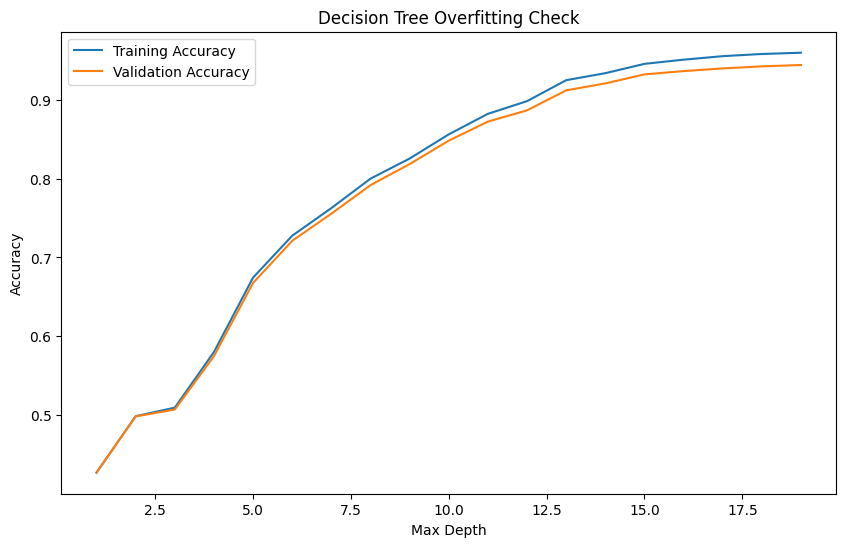

In [ ]:
#Draw curves for accuracy and validation scores in order to estimate the optimum max_depth for the Decision Tree model

# Initialize lists to store training and validation scores
train_scores = []
val_scores = []
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.3, random_state=42)

# Test different values for max_depth
depths_to_test = range(1, 20)
for depth in depths_to_test:
    # Create and train the decision tree model
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions on training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_scores.append(train_accuracy)
    
    # Predictions on validation set
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_scores.append(val_accuracy)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(depths_to_test, train_scores, label='Training Accuracy')
plt.plot(depths_to_test, val_scores, label='Validation Accuracy')
plt.title('Decision Tree Overfitting Check')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the above graph, we can observe  that the accuracy score plateaus after approximately 17 trees. Based on this, we will set the max_depth parameter at this number. 

In [168]:
#Decision Tress
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Instantiate a Random Forest classifier
dt_clf2=DecisionTreeClassifier(criterion="gini", max_depth=17, random_state=123) # create classifier

#Fit the model
dt_clf2.fit(X_train, y_train) 

# Make predictions on the test set
y_pred_dt2= dt_clf2.predict(X_test) # Apply the model

#Evaluation of the model
print(dt_clf2.score(X_test, y_test)) #Display the model score
score_dt2=dt_clf2.score(X_test, y_test) #Store model score

accuracy_dt2 = accuracy_score(y_test, y_pred_dt2) #Store accuracy score

print(pd.crosstab(y_test, y_pred_dt2, rownames=['Real'], colnames=['Predicted'])) #Display confusion matrix
con_matrix_dt2=pd.crosstab(y_test, y_pred_dt2, rownames=['Real'], colnames=['Predicted']) #Compute and store confusion matrix

print(classification_report(y_test, y_pred_dt2)) #Display classification report
class_report_dt2=classification_report(y_test, y_pred_dt2, output_dict=True) #Compute and store classification report
class_report_dt2 = pd.DataFrame(class_report_dt2).transpose() #Convert classification report to dataframe and transpose


0.9519413858763143
Predicted    A     B     C     D     E    F
Real                                       
A          957    49     0     0     0    0
B           75  5449   286     2     1    0
C            0   258  9814   200     1    0
D            0     7   105  4104    53    1
E            0     0     6    93  2475    9
F            0     0     1     0    14  198
              precision    recall  f1-score   support

           A       0.93      0.95      0.94      1006
           B       0.95      0.94      0.94      5813
           C       0.96      0.96      0.96     10273
           D       0.93      0.96      0.95      4270
           E       0.97      0.96      0.97      2583
           F       0.95      0.93      0.94       213

    accuracy                           0.95     24158
   macro avg       0.95      0.95      0.95     24158
weighted avg       0.95      0.95      0.95     24158

                         Importance
Mass                       0.296091
Eng_Power     

In [174]:
# For better visualization of the scores in the .word file, create a data frame with the classification report and the confusion matrix

separator_column = pd.DataFrame({'|': []}) #Instantiate a separator column
dt2_eval=pd.concat([class_report_dt2,separator_column,con_matrix_dt2 ],axis=1) #Concatenate classication report, separator column and confusion matrix (better keep matrix on the right)
dt2_eval["|"]=dt2_eval["|"].fillna("|") #Fill the separator column with "|" characters 
dt2_eval=dt2_eval.fillna("-") #Fill the empty cells with "-" characters for aesthetic purposes
dt2_eval.head(15) #Display 

,precision,recall,f1-score,support,|,A,B,C,D,E,F
A,0.927326,0.951292,0.939156,1006.000000,|,957.0,49.0,0.0,0.0,0.0,0.0
B,0.945514,0.937382,0.941431,5813.000000,|,75.0,5449.0,286.0,2.0,1.0,0.0
C,0.961026,0.955320,0.958165,10273.000000,|,0.0,258.0,9814.0,200.0,1.0,0.0
D,0.932939,0.961124,0.946822,4270.000000,|,0.0,7.0,105.0,4104.0,53.0,1.0
E,0.972877,0.958188,0.965477,2583.000000,|,0.0,0.0,6.0,93.0,2475.0,9.0
F,0.951923,0.929577,0.940618,213.000000,|,0.0,0.0,1.0,0.0,14.0,198.0
accuracy,0.951941,0.951941,0.951941,0.951941,|,-,-,-,-,-,-
macro avg,0.948601,0.948814,0.948611,24158.000000,|,-,-,-,-,-,-
weighted avg,0.952113,0.951941,0.951969,24158.000000,|,-,-,-,-,-,-


                         Importance
Mass                       0.296091
Eng_Power                  0.208844
Axle_Width                 0.090824
Eng_Capacity               0.089281
Wheel_Base                 0.088285
Fuel_Mode_H                0.039768
Fuel_Type_diesel           0.037568
TOYOTA                     0.036126
Fuel_Type_petrol           0.033124
FIAT GROUP                 0.020028
ERT                        0.010392
Fuel_Type_lpg              0.009236
RENAULT                    0.009041
VOLKSWAGEN                 0.006781
FORD WERKE GMBH            0.005603
SKODA                      0.005427
AUTOMOBILES PEUGEOT        0.004039
AUDI AG                    0.003683
BMW AG                     0.002775
DAIMLER AG                 0.002717
Fuel_Mode_M                0.000255
Fuel_Mode_B                0.000051
Four_Wheel_Drive           0.000043
Fuel_Type_ng-biomethane    0.000015
Fuel_Mode_F                0.000002
Fuel_Type_e85              0.000000
Fuel_Type_ng               0

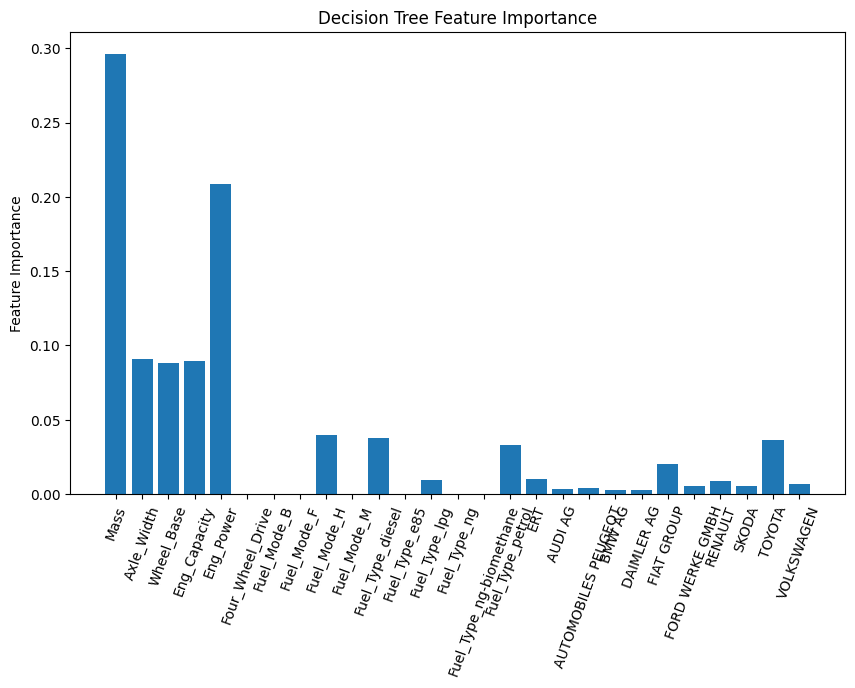

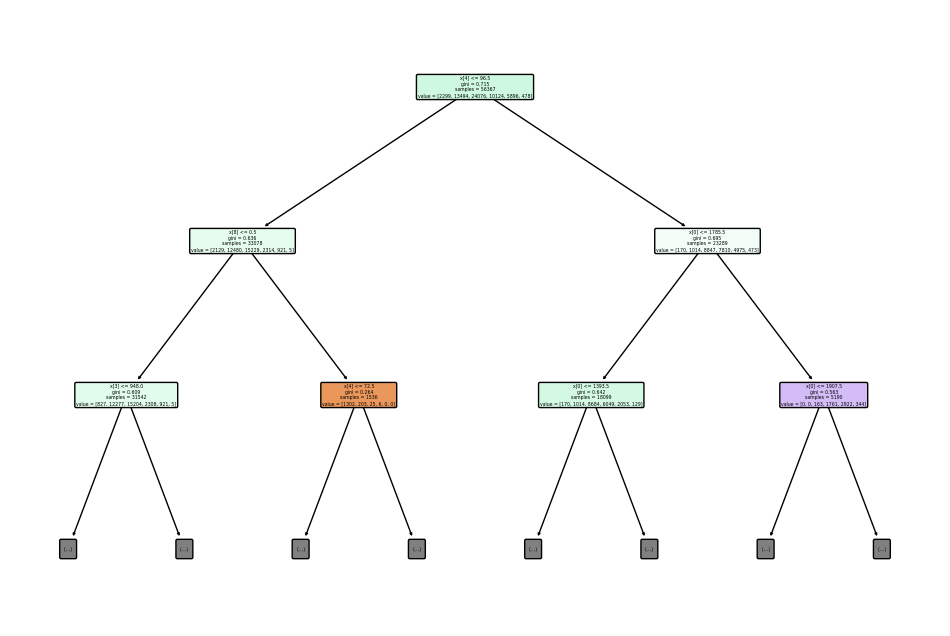

In [262]:
#Plot the feature importance

feats = {}  #To find the normalized importance of each variable in the tree construction
for feature, importance in zip(data.columns, dt_clf2.feature_importances_):
    feats[feature] = importance 
    
importances_dt2 = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
print(importances_dt2.sort_values(by='Importance', ascending=False))

#Plot the tree with most important features

# Get feature importances from the trained model
feature_importances = dt_clf2.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})


# Get the names of the features
feature_names = data.columns

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align='center')
plt.xticks(np.arange(len(feature_names)), feature_names,rotation=70)
plt.ylabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
plt.show()


In [189]:
#Create a dataframe with the feature importance in descending order

feature_importance_df=feature_importance_df.sort_values(by='Importance', ascending=False) #sort
feature_importance_df.head(50) #Display

,Feature,Importance
0,Mass,0.296091
4,Eng_Power,0.208844
1,Axle_Width,0.090824
3,Eng_Capacity,0.089281
2,Wheel_Base,0.088285
8,Fuel_Mode_H,0.039768
10,Fuel_Type_diesel,0.037568
25,TOYOTA,0.036126
15,Fuel_Type_petrol,0.033124
21,FIAT GROUP,0.020028


Random Forest Classifier

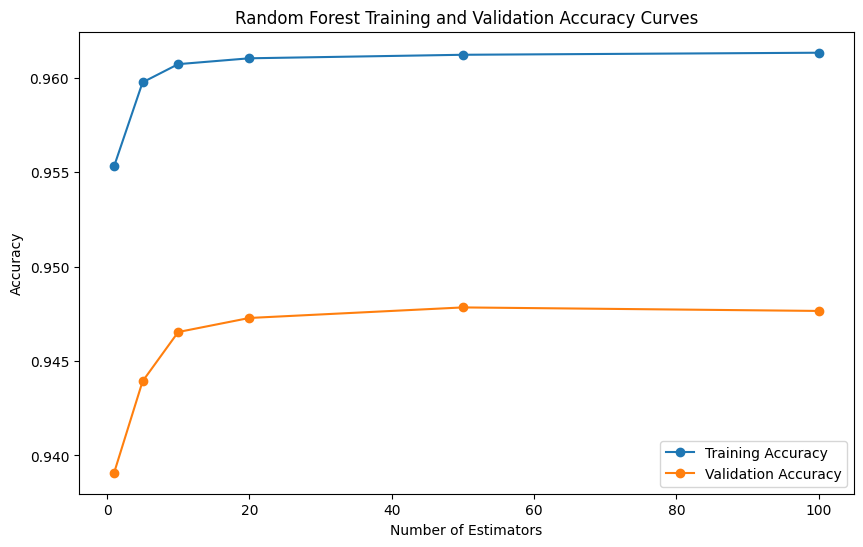

In [ ]:
#Draw the training and validation accuracy curves in order to estimate the n_estimators for Random Forest model

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, random_state=42)

# Define a range of numbers of estimators
estimator_range = [1, 5, 10, 20, 50, 100]

# Lists to store training and validation accuracies
train_accuracies = []
valid_accuracies = []

# Train Random Forest models with different numbers of estimators
for n_estimators in estimator_range:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predict on validation set
    y_valid_pred = model.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)
    valid_accuracies.append(valid_accuracy)

# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(estimator_range, valid_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Training and Validation Accuracy Curves')
plt.legend()
plt.show()

From the above graph, we can observe that the accuracy plateaus after approximately 50 estimators. Based on this, we will set n_estimators at this number.

In [ ]:
#Random forest model, after selection of parameters

from sklearn.ensemble import RandomForestClassifier #Import the library

#Instantiate a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42) 

#Fit the model
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test)

#Instantiate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf) #Calculate and store the accuracy score

class_report_rf= classification_report(y_test, y_pred_rf, output_dict=True) #Compute and store the classification report
class_report_rf = pd.DataFrame(class_report_rf).transpose() #Convert the classification report to dataframe and transpose

score_rf=rf_clf.score(X_test, y_test) #Compute and store the model score

conf_matrix_rf=pd.crosstab(y_test, y_pred_rf, rownames=['Real'], colnames=['Predicted']) #Compute and store the confusion matrix

print(accuracy_rf) #Display accuracy score
print(score_rf) #Display model score
print(conf_matrix_rf) #Display confusion matrix
print(class_report_rf) #Display classification report


0.9600546402847918
0.9600546402847918
Predicted    A     B     C     D     E    F
Real                                       
A          957    49     0     0     0    0
B           73  5504   233     3     0    0
C            0   219  9870   184     0    0
D            0     1    87  4142    40    0
E            0     0     3    61  2518    1
F            0     0     1     0    10  202
              precision    recall  f1-score       support
A              0.929126  0.951292  0.940079   1006.000000
B              0.953404  0.946843  0.950112   5813.000000
C              0.968217  0.960771  0.964479  10273.000000
D              0.943508  0.970023  0.956582   4270.000000
E              0.980530  0.974835  0.977674   2583.000000
F              0.995074  0.948357  0.971154    213.000000
accuracy       0.960055  0.960055  0.960055      0.960055
macro avg      0.961643  0.958687  0.960013  24158.000000
weighted avg   0.960210  0.960055  0.960080  24158.000000


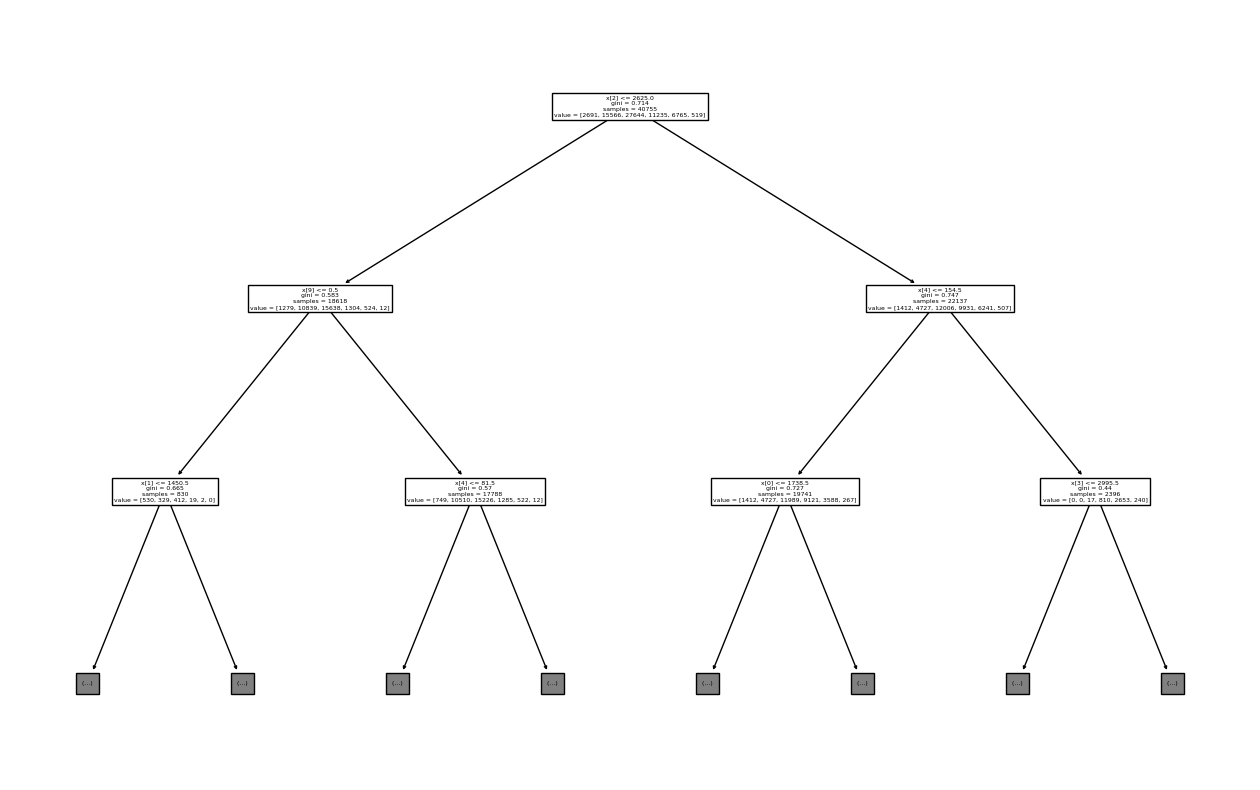

In [ ]:
# Create a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
rf_clf.fit(X_train, y_train)

# Select one tree from the forest for visualization (e.g., the first tree)
selected_tree = rf_clf.estimators_[0]

# Plot the selected tree with pruning and a larger figure size
plt.figure(figsize=(16, 10))
plot_tree(selected_tree, max_depth=2)
plt.show()

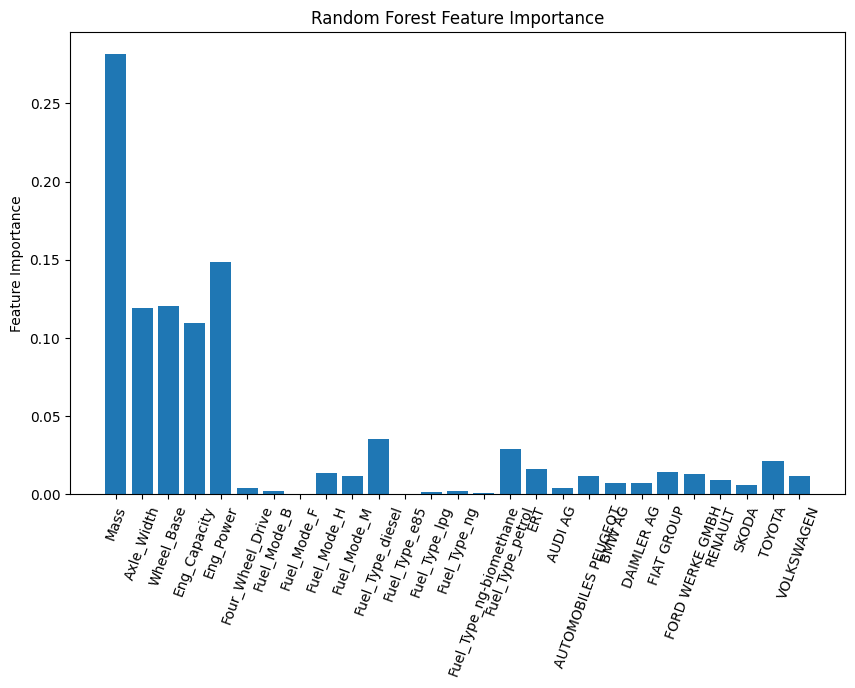

,Feature,Importance
0,Mass,0.281630
4,Eng_Power,0.148671
2,Wheel_Base,0.120468
1,Axle_Width,0.119286
3,Eng_Capacity,0.109698
10,Fuel_Type_diesel,0.035382
15,Fuel_Type_petrol,0.028904
25,TOYOTA,0.021302
16,ERT,0.016094
21,FIAT GROUP,0.014167


In [ ]:
# Get feature importances from the trained model
feature_importances_rf = rf_clf.feature_importances_
feature_importance_rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_rf})


# Get the names of the features
feature_names = data.columns

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances_rf, align='center')
plt.xticks(np.arange(len(feature_names)), feature_names,rotation=70)
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

feature_importance_rf_df=feature_importance_rf_df.sort_values(by='Importance', ascending=False)
feature_importance_rf_df.head(50)


In [ ]:
# For better visualization of the scores in the .word file, create a data frame with the classification report and the confusion matrix

separator_column = pd.DataFrame({'|': []}) #Instantiate a separator column 
rf_eval=pd.concat([class_report_rf,separator_column,conf_matrix_rf],axis=1) #Concatenate classication report, separator column and confusion matrix (better keep matrix on the right)
rf_eval["|"]=rf_eval["|"].fillna("|") #Fill the separator column with "|" characters 
rf_eval=rf_eval.fillna("-") #Fill the empty cells with "-" characters for better aesthetics
rf_eval.head(15) #Display

,precision,recall,f1-score,support,|,A,B,C,D,E,F
A,0.929126,0.951292,0.940079,1006.000000,|,957.0,49.0,0.0,0.0,0.0,0.0
B,0.953404,0.946843,0.950112,5813.000000,|,73.0,5504.0,233.0,3.0,0.0,0.0
C,0.968217,0.960771,0.964479,10273.000000,|,0.0,219.0,9870.0,184.0,0.0,0.0
D,0.943508,0.970023,0.956582,4270.000000,|,0.0,1.0,87.0,4142.0,40.0,0.0
E,0.980530,0.974835,0.977674,2583.000000,|,0.0,0.0,3.0,61.0,2518.0,1.0
F,0.995074,0.948357,0.971154,213.000000,|,0.0,0.0,1.0,0.0,10.0,202.0
accuracy,0.960055,0.960055,0.960055,0.960055,|,-,-,-,-,-,-
macro avg,0.961643,0.958687,0.960013,24158.000000,|,-,-,-,-,-,-
weighted avg,0.960210,0.960055,0.960080,24158.000000,|,-,-,-,-,-,-


Voting classifier
    Create different ensemble models based on the selection of the base estimators

In [232]:
#Voting classifier v1 with KNN, Random Forest and Logistic regression as base estimators

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Instantiate the base estimators 
clf1 = neighbors.KNeighborsClassifier(n_neighbors=5)
clf2 = RandomForestClassifier(n_estimators=50, random_state=123)
clf3 = LogisticRegression(max_iter=1000)

#Instantiate Voting classifier
vclf1 = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')
    #estimators: a list containing for each estimator a label and the name of the estimator.
    #voting : allows to specify the voting method (hard or soft). 

# Train the ensemble model
vclf1.fit(X_train, y_train)

# Make predictions on the test set
y_pred_vclf1= vclf1.predict(X_test)

# Evaluate the ensemble model
accurac_vclf1 = accuracy_score(y_test, y_pred_vclf1)
class_report_vclf1 = classification_report(y_test, y_pred_vclf1, output_dict=True)
class_report_vclf1 = pd.DataFrame(class_report_vclf1).transpose()

score_vclf1=vclf1.score(X_test, y_test)
print("Model score is:", vclf1.score(X_test, y_test))

print(pd.crosstab(y_test, y_pred_vclf1, rownames=['Real'], colnames=['Predicted'])) # Display confusion matrix
con_matrix_vclf1=pd.crosstab(y_test, y_pred_vclf1, rownames=['Real'], colnames=['Predicted'])

# Display the results
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_vclf1))


class_report_rf = pd.DataFrame(class_report_rf).transpose()

c:\Users\Pinelopi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model score is: 0.9466429340177167
Predicted    A     B     C     D     E    F
Real                                       
A          888   115     3     0     0    0
B           41  5443   327     2     0    0
C            3   219  9942   107     2    0
D            4    22   260  3924    60    0
E            0     0    28    72  2481    2
F            0     0     1     0    21  191
Accuracy: 0.94
              precision    recall  f1-score   support

           A       0.95      0.88      0.91      1006
           B       0.94      0.94      0.94      5813
           C       0.94      0.97      0.95     10273
           D       0.96      0.92      0.94      4270
           E       0.97      0.96      0.96      2583
           F       0.99      0.90      0.94       213

    accuracy                           0.95     24158
   macro avg       0.96      0.93      0.94     24158
weighted avg       0.95      0.95      0.95     24158



In [233]:
# For better visualization of the scores in the .word file, create a data frame with the classification report and the confusion matrix

separator_column = pd.DataFrame({'|': []}) #Instantiate a separator column
vclf1_eval=pd.concat([class_report_vclf1,separator_column,con_matrix_vclf1],axis=1) #Concatenate classication report, separator column and confusion matrix (better keep matrix on the right)
vclf1_eval["|"]=vclf1_eval["|"].fillna("|") #Fill the separator column with "|" characters 
vclf1_eval=vclf1_eval.fillna("-") #Fill the empty cells with "-" characters for aesthetic purposes
vclf1_eval.head(15) #Display

,precision,recall,f1-score,support,|,A,B,C,D,E,F
A,0.948718,0.882704,0.914521,1006.000000,|,888.0,115.0,3.0,0.0,0.0,0.0
B,0.938610,0.936350,0.937478,5813.000000,|,41.0,5443.0,327.0,2.0,0.0,0.0
C,0.941388,0.967780,0.954401,10273.000000,|,3.0,219.0,9942.0,107.0,2.0,0.0
D,0.955907,0.918970,0.937075,4270.000000,|,4.0,22.0,260.0,3924.0,60.0,0.0
E,0.967629,0.960511,0.964057,2583.000000,|,0.0,0.0,28.0,72.0,2481.0,2.0
F,0.989637,0.896714,0.940887,213.000000,|,0.0,0.0,1.0,0.0,21.0,191.0
accuracy,0.946643,0.946643,0.946643,0.946643,|,-,-,-,-,-,-
macro avg,0.956982,0.927171,0.941403,24158.000000,|,-,-,-,-,-,-
weighted avg,0.946822,0.946643,0.946519,24158.000000,|,-,-,-,-,-,-


In [230]:
#Voting classifier v2 with KNN, Random Forest and Decision Tree classifiers as base estimators

from sklearn.ensemble import VotingClassifier #Import library

#Instantiate the base estimators 
clf1 = neighbors.KNeighborsClassifier(n_neighbors=5) #Instantiate KNN model classifier
clf2 = RandomForestClassifier(n_estimators=50, random_state=123) #Instantiate Random Forest classifier
clf3 = DecisionTreeClassifier(criterion="gini", max_depth=17, random_state=123) #Instantiate Decision Tree classifier

#Instantiate Voting classifier
vclf2 = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('dt', clf3)], voting='hard') 
    #estimators: a list containing for each estimator a label and the name of the estimator.
    #voting : allows to specify the voting method (hard or soft). 

# Train the ensemble model
vclf2.fit(X_train, y_train)

# Make predictions on the test set
y_pred_vclf2= vclf2.predict(X_test)

# Evaluate the ensemble model
accuracy_vclf2 = accuracy_score(y_test, y_pred_vclf2)
class_report_vclf2 = classification_report(y_test, y_pred_vclf2,output_dict=True)
class_report_vclf2 = pd.DataFrame(class_report_vclf2).transpose()

print("Model score is:", vclf2.score(X_test, y_test))
score_vclf2=vclf2.score(X_test, y_test)

print(pd.crosstab(y_test, y_pred_vclf2, rownames=['Real'], colnames=['Predicted'])) # Display confusion matrix
con_matrix_vclf2=pd.crosstab(y_test, y_pred_vclf2, rownames=['Real'], colnames=['Predicted'])

# Display the results
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_vclf2))


Model score is: 0.9579021442172365
Predicted    A     B     C     D     E    F
Real                                       
A          957    49     0     0     0    0
B           74  5484   254     1     0    0
C            0   226  9864   183     0    0
D            0     4    99  4124    43    0
E            0     0     7    63  2511    2
F            0     0     1     0    11  201
Accuracy: 0.94
              precision    recall  f1-score   support

           A       0.93      0.95      0.94      1006
           B       0.95      0.94      0.95      5813
           C       0.96      0.96      0.96     10273
           D       0.94      0.97      0.95      4270
           E       0.98      0.97      0.98      2583
           F       0.99      0.94      0.97       213

    accuracy                           0.96     24158
   macro avg       0.96      0.96      0.96     24158
weighted avg       0.96      0.96      0.96     24158



In [231]:
# For better visualization of the scores in the .word file, create a data frame with the classification report and the confusion matrix

separator_column = pd.DataFrame({'|': []}) #Instantiate a separator column
vclf2_eval=pd.concat([class_report_vclf2,separator_column,con_matrix_vclf2],axis=1) #Concatenate classication report, separator column and confusion matrix (better keep matrix on the right)
vclf2_eval["|"]=vclf2_eval["|"].fillna("|") #Fill the separator column with "|" characters 
vclf2_eval=vclf2_eval.fillna("-") #Fill the empty cells with "-" characters for aesthetic purposes
vclf2_eval.head(15) #Display

,precision,recall,f1-score,support,|,A,B,C,D,E,F
A,0.928225,0.951292,0.939617,1006.000000,|,957.0,49.0,0.0,0.0,0.0,0.0
B,0.951588,0.943403,0.947478,5813.000000,|,74.0,5484.0,254.0,1.0,0.0,0.0
C,0.964694,0.960187,0.962435,10273.000000,|,0.0,226.0,9864.0,183.0,0.0,0.0
D,0.943491,0.965808,0.954519,4270.000000,|,0.0,4.0,99.0,4124.0,43.0,0.0
E,0.978947,0.972125,0.975524,2583.000000,|,0.0,0.0,7.0,63.0,2511.0,2.0
F,0.990148,0.943662,0.966346,213.000000,|,0.0,0.0,1.0,0.0,11.0,201.0
accuracy,0.957902,0.957902,0.957902,0.957902,|,-,-,-,-,-,-
macro avg,0.959516,0.956080,0.957653,24158.000000,|,-,-,-,-,-,-
weighted avg,0.958023,0.957902,0.957921,24158.000000,|,-,-,-,-,-,-


Hyperparameter selection with GriSearchCV
    Unfortunately, this needs a PC with high computational power otherwise it does not run!

In [73]:
from sklearn.model_selection import  GridSearchCV

# Define the individual classifiers 
clf1 = neighbors.KNeighborsClassifier()
clf2 = RandomForestClassifier()
clf3 = DecisionTreeClassifier()

# Create a VotingClassifier
vclf= VotingClassifier(estimators=[
    ('knn', clf1), 
    ('rf', clf2), 
    ('dt', clf3)],
    voting='hard'
)
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'rf__n_estimators': [50, 100, 150],
    'dt__max_depth': [5, 10, 15,20,25],
    #'estimators': [[('knn', clf1), ('rf', clf2)], [('dt', clf3)]]
}

# Create the GridSearchCV object
grid_search1 = GridSearchCV(estimator=vclf, param_grid=param_grid, scoring='accuracy')

In [ ]:
#Previous trials failed. We will repeat this approach with a fraction of the dataset.

#Fit the grid search to the data
sample = df_class.sample(frac=0.5, random_state=42)
target_s = sample.CO2_Classes 
data_s =sample.drop( "CO2_Classes", axis=1)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(data_s, target_s, test_size=0.3, random_state=66) #Split into train and test

grid_search1.fit(X_train_s, y_train_s)


In [ ]:

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f'Best Hyperparameters: {best_params}')

# Make predictions on the test set using the best estimator
y_pred_grid = best_estimator.predict(X_test_scaled)

# Evaluate the best estimator
accuracy = accuracy_score(y_test, y_pred_grid)
print(f'Accuracy: {accuracy:.2f}')

print(pd.crosstab(y_test, y_pred_grid, rownames=['Real'], colnames=['Predicted'])) # Display confusion matrix
print(classification_report(y_test, y_pred_grid))

Stacking classifier: Use a set of base classifiers (KNN, Random Forest and Decision Tree) and test different meta-classifiers.
    For base classifiers, we selected the most successful models

In [236]:
#Stacking classifier v1 (base classifiers and Gradient Boost as meta-classifier)

from sklearn.ensemble import  StackingClassifier #Import stacking classifier library
from sklearn.ensemble import GradientBoostingClassifier #Import Gradient Boost library

# Define the base classifiers
base_classifiers = [
    ('knn', neighbors.KNeighborsClassifier(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    #('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('dt', DecisionTreeClassifier(criterion="gini", max_depth=17, random_state=123))
    ]

# Define the meta-classifier
meta_classifier = GradientBoostingClassifier()

# Create the StackingClassifier
stack_clf = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the stacking classifier on the training data
stack_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_stack_clf = stack_clf.predict(X_test)

# Evaluate the performance
accuracy_stack_clf = accuracy_score(y_test, y_pred_stack_clf)
print("Model score is:", stack_clf.score(X_test, y_test))
score_stack_clf=stack_clf.score(X_test, y_test)

print(pd.crosstab(y_test, y_pred_stack_clf, rownames=['Real'], colnames=['Predicted'])) # Display confusion matrix
con_matrix_stack_clf=pd.crosstab(y_test, y_pred_stack_clf, rownames=['Real'], colnames=['Predicted'])

print(classification_report(y_test, y_pred_stack_clf))
class_report_stack_clf=classification_report(y_test, y_pred_stack_clf, output_dict=True)
class_report_stack_clf = pd.DataFrame(class_report_stack_clf).transpose()


Model score is: 0.9557496481496812
Predicted    A     B     C     D     E    F
Real                                       
A          864   142     0     0     0    0
B           49  5524   238     2     0    0
C            0   227  9858   188     0    0
D            0     1    92  4132    45    0
E            0     0     3    61  2512    7
F            0     0     1     0    13  199
              precision    recall  f1-score   support

           A       0.95      0.86      0.90      1006
           B       0.94      0.95      0.94      5813
           C       0.97      0.96      0.96     10273
           D       0.94      0.97      0.96      4270
           E       0.98      0.97      0.97      2583
           F       0.97      0.93      0.95       213

    accuracy                           0.96     24158
   macro avg       0.96      0.94      0.95     24158
weighted avg       0.96      0.96      0.96     24158



In [237]:
#Stacking classifier v2 (base classifiers and Bagging Classifier as meta-classifier)

from sklearn.ensemble import BaggingClassifier #Import library

#Create a list with the base classification models 
base_classifiers = [
    ('knn', neighbors.KNeighborsClassifier(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    #('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('dt', DecisionTreeClassifier(criterion="gini", random_state=123))
    ]

# Define the meta-classifier
meta_classifier = BaggingClassifier()

# Create the StackingClassifier
stack_clf2 = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the stacking classifier on the training data
stack_clf2.fit(X_train, y_train)

# Make predictions on the test data
y_pred_stack_clf2 = stack_clf2.predict(X_test)

# Evaluate the performance
accuracy_stack_clf2 = accuracy_score(y_test, y_pred_stack_clf2) #Calculate and store the accuracy score of the model

print("Model score is:", stack_clf2.score(X_test, y_test)) #Display model score
score_stack_clf2=stack_clf.score(X_test, y_test) #Store model score

print(pd.crosstab(y_test, y_pred_stack_clf2, rownames=['Real'], colnames=['Predicted'])) #Display confusion matrix
con_matrix_stack_clf2=pd.crosstab(y_test, y_pred_stack_clf2, rownames=['Real'], colnames=['Predicted']) #Store confusion matrix

print(classification_report(y_test, y_pred_stack_clf2)) #Display classification report
class_report_stack_clf2=classification_report(y_test, y_pred_stack_clf2, output_dict=True) #Store classification report
class_report_stack_clf2 = pd.DataFrame(class_report_stack_clf2).transpose() #Convert to dataframe and transpose


Model score is: 0.9501200430499214
Predicted    A     B     C     D     E    F
Real                                       
A          957    49     0     0     0    0
B           73  5435   302     3     0    0
C            0   240  9876   157     0    0
D            0     3   185  4024    58    0
E            0     0     3   110  2467    3
F            0     0     1     0    18  194
              precision    recall  f1-score   support

           A       0.93      0.95      0.94      1006
           B       0.95      0.93      0.94      5813
           C       0.95      0.96      0.96     10273
           D       0.94      0.94      0.94      4270
           E       0.97      0.96      0.96      2583
           F       0.98      0.91      0.95       213

    accuracy                           0.95     24158
   macro avg       0.95      0.94      0.95     24158
weighted avg       0.95      0.95      0.95     24158



In [238]:
#Stacking classifier v3 (base classifiers and XGBoost as meta-classifier)

from xgboost import XGBClassifier #Import library

#Create a list with the base classification models 
base_classifiers = [
    ('knn', neighbors.KNeighborsClassifier(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    #('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('dt', DecisionTreeClassifier(criterion="gini", max_depth=17, random_state=123))
    ]

# Define the meta-classifier
meta_classifier = XGBClassifier()

# Create the StackingClassifier
stack_clf3 = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the stacking classifier on the training data
stack_clf3.fit(X_train, y_train)

# Make predictions on the test data
y_pred_stack_clf3 = stack_clf3.predict(X_test)

# Evaluate the performance
accuracy_stack_clf3 = accuracy_score(y_test, y_pred_stack_clf3) #Calculate and store the accuracy score of the model

print("Model score is:", stack_clf3.score(X_test, y_test)) #Display model score
score_stack_clf3=stack_clf.score(X_test, y_test) #Store model score

print(pd.crosstab(y_test, y_pred_stack_clf3, rownames=['Real'], colnames=['Predicted'])) #Display confusion matrix
con_matrix_stack_clf3=pd.crosstab(y_test, y_pred_stack_clf3, rownames=['Real'], colnames=['Predicted']) #Store confusion matrix

print(classification_report(y_test, y_pred_stack_clf3)) #Display classification report
class_report_stack_clf3=classification_report(y_test, y_pred_stack_clf3, output_dict=True) #Store classification report
class_report_stack_clf3 = pd.DataFrame(class_report_stack_clf3).transpose() #Convert to dataframe and transpose


Model score is: 0.9580263266826724
Predicted    A     B     C     D     E    F
Real                                       
A          957    49     0     0     0    0
B           73  5501   237     2     0    0
C            0   232  9845   196     0    0
D            0     1    88  4130    51    0
E            0     0     3    63  2516    1
F            0     0     1     0    17  195
              precision    recall  f1-score   support

           A       0.93      0.95      0.94      1006
           B       0.95      0.95      0.95      5813
           C       0.97      0.96      0.96     10273
           D       0.94      0.97      0.95      4270
           E       0.97      0.97      0.97      2583
           F       0.99      0.92      0.95       213

    accuracy                           0.96     24158
   macro avg       0.96      0.95      0.96     24158
weighted avg       0.96      0.96      0.96     24158



In [243]:
# For better visualization of the scores in the .word file, create a data frame with the classification report and the confusion matrix

separator_column = pd.DataFrame({'|': []}) #Instantiate a separator column 

stack_clf3_eval=pd.concat([class_report_stack_clf,separator_column,con_matrix_stack_clf],axis=1) #Concatenate classication report, separator column and confusion matrix (better keep matrix on the right)
stack_clf3_eval["|"]=stack_clf1_eval["|"].fillna("|") #Fill the separator column with "|" characters 
stack_clf3_eval=stack_clf1_eval.fillna("-") #Fill the empty cells with "-" characters for aesthetic purposes
stack_clf3_eval.head(15) #Display

,precision,recall,f1-score,support,|,A,B,C,D,E,F
A,0.929126,0.951292,0.940079,1006.000000,|,957.0,49.0,0.0,0.0,0.0,0.0
B,0.951236,0.946327,0.948775,5813.000000,|,73.0,5501.0,237.0,2.0,0.0,0.0
C,0.967663,0.958337,0.962977,10273.000000,|,0.0,232.0,9845.0,196.0,0.0,0.0
D,0.940560,0.967213,0.953700,4270.000000,|,0.0,1.0,88.0,4130.0,51.0,0.0
E,0.973684,0.974061,0.973873,2583.000000,|,0.0,0.0,3.0,63.0,2516.0,1.0
F,0.994898,0.915493,0.953545,213.000000,|,0.0,0.0,1.0,0.0,17.0,195.0
accuracy,0.958026,0.958026,0.958026,0.958026,|,-,-,-,-,-,-
macro avg,0.959528,0.952121,0.955492,24158.000000,|,-,-,-,-,-,-
weighted avg,0.958199,0.958026,0.958049,24158.000000,|,-,-,-,-,-,-


In [244]:
#Create matrix with all accuracy scores (can be used in .word file)

#Create list with all the model scores (manually)
#df_score_manhattan = pd.DataFrame(score_manhattan)
list_model_scores={"KNN (Manhattan metric)": score_manhattan, "KNN (Minkowski metric)": score_minkowski, "Decision trees":score_dt2, "Random Forest":score_rf,
                   "Voting classifier 1": score_vclf1, "Voting classifier 2": score_vclf2,
                   "Stacking classifier 1": score_stack_clf, "Stacking classifier 2": score_stack_clf2, "Stacking classifier 3": score_stack_clf3}
print(list_model_scores)

#Create list with all the accuracy scores (manually)
list_acc_scores={"KNN (Manhattan metric)":accuracy_knn_man, "KNN (Minkowski metric)": accuracy_knn_min, "Decision trees":accuracy_dt2, "Random Forest":accuracy_rf,
                 "Voting classifier 1": accurac_vclf1, "Voting classifier 2": accuracy_vclf2,
                 "Stacking classifier 1": accuracy_stack_clf, "Stacking classifier 2": accuracy_stack_clf2, "Stacking classifier 3": accuracy_stack_clf3}
print(list_acc_scores)


{'KNN (Manhattan metric)': 0.9397301101084526, 'KNN (Minkowski metric)': 0.9373706432651709, 'Decision trees': 0.9519413858763143, 'Random Forest': 0.9600546402847918, 'Voting classifier 1': 0.9466429340177167, 'Voting classifier 2': 0.9579021442172365, 'Stacking classifier 1': 0.9557496481496812, 'Stacking classifier 2': 0.9557496481496812, 'Stacking classifier 3': 0.9557496481496812}
{'KNN (Manhattan metric)': 0.9397301101084526, 'KNN (Minkowski metric)': 0.9373706432651709, 'Decision trees': 0.9519413858763143, 'Random Forest': 0.9600546402847918, 'Voting classifier 1': 0.9466429340177167, 'Voting classifier 2': 0.9579021442172365, 'Stacking classifier 1': 0.9557496481496812, 'Stacking classifier 2': 0.9501200430499214, 'Stacking classifier 3': 0.9580263266826724}


In [245]:
# Convert list with model scores to dataframe
model_scores = pd.DataFrame(list_model_scores.items(), columns=['Model', 'R2 score'])
model_scores.head()

# Convert list with accuracy scores to dataframe
accuracy_scores=pd.DataFrame(list_acc_scores.items(), columns=['Model', 'Accuracy score'])
accuracy_scores.head(10)

#Merge dataframes on model name
all_scores= pd.merge(accuracy_scores, model_scores, on='Model', how='inner')
all_scores.head(15)

,Model,Accuracy score,R2 score
0,KNN (Manhattan metric),0.939730,0.939730
1,KNN (Minkowski metric),0.937371,0.937371
2,Decision trees,0.951941,0.951941
3,Random Forest,0.960055,0.960055
4,Voting classifier 1,0.946643,0.946643
5,Voting classifier 2,0.957902,0.957902
6,Stacking classifier 1,0.955750,0.955750
7,Stacking classifier 2,0.950120,0.955750
8,Stacking classifier 3,0.958026,0.955750
